In [87]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,avg, sum, to_date, month, count
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Create a spark Session
spark = SparkSession.builder \
    .appName("Amazon") \
    .getOrCreate()

csv_file_path = r"Dataset\Amazon.csv"
df = spark.read.csv(csv_file_path, header="true", inferSchema=True)


In [88]:
df_clean = (
    df
    .filter((col("Status").contains("Shipped")) & (col("Fulfilment")=="Amazon") & (col("Sales Channel ")=="Amazon.in"))           
            )

df_clean = df_clean.withColumn("parsed_date", to_date("Date", "MM-dd-yy"))
df_clean = df_clean.withColumn("month", month("parsed_date"))
df_clean=df_clean.drop("fulfilled-by", "Unnamed: 22", " Sales Channel ", "promotion-ids", "Date")
df_clean= df_clean.dropna(subset=["Order ID", "Status", "Fulfilment", "Sales Channel ", "Qty", "Amount"])

In [89]:
df_clean.show()

+-----+-------------------+-------+----------+--------------+------------------+--------+-----------------+-------------+----+----------+--------------+---+--------+------+---------------+-------------+----------------+------------+-----+-----------+-----+
|index|           Order ID| Status|Fulfilment|Sales Channel |ship-service-level|   Style|              SKU|     Category|Size|      ASIN|Courier Status|Qty|currency|Amount|      ship-city|   ship-state|ship-postal-code|ship-country|  B2B|parsed_date|month|
+-----+-------------------+-------+----------+--------------+------------------+--------+-----------------+-------------+----+----------+--------------+---+--------+------+---------------+-------------+----------------+------------+-----+-----------+-----+
|    2|404-0687676-7273146|Shipped|    Amazon|     Amazon.in|         Expedited| JNE3371|    JNE3371-KR-XL|        kurta|  XL|B07WV4JV4D|       Shipped|  1|     INR| 329.0|    NAVI MUMBAI|  MAHARASHTRA|        410210.0|          

In [90]:
df_category=df_clean.groupBy("Category").agg(
    avg("Amount").alias("avg_amount"),
    sum("Amount").alias("total_amount")
).orderBy("avg_amount", ascending=False)
df_category = df_category.toPandas()
df_category.set_index("Category")

scaler=MinMaxScaler()
df_category["Standardized_Amount"]=scaler.fit_transform(df_category[["total_amount"]])

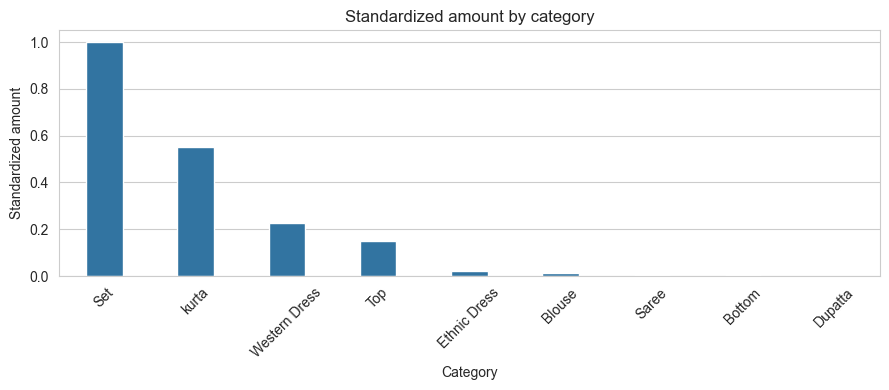

In [94]:
df_category_sorted = df_category.sort_values("total_amount", ascending=False)

plt.figure(figsize=(9, 4))
sns.barplot(data=df_category_sorted, x="Category", y="Standardized_Amount", width=0.4)

plt.title("Standardized amount by category")
plt.xlabel("Category")
plt.ylabel("Standardized amount")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [92]:
df_month=df_clean.groupBy("month").agg(
    count("Order ID").alias("orders"),
    sum("Amount").alias("total_amount")
).orderBy("orders", ascending=False)
df_month = df_month.toPandas()
df_month.set_index("month")

,orders,total_amount
month,,
4,28855,18211506.0
5,24961,16530004.0
6,23645,15498732.0
3,135,84013.0


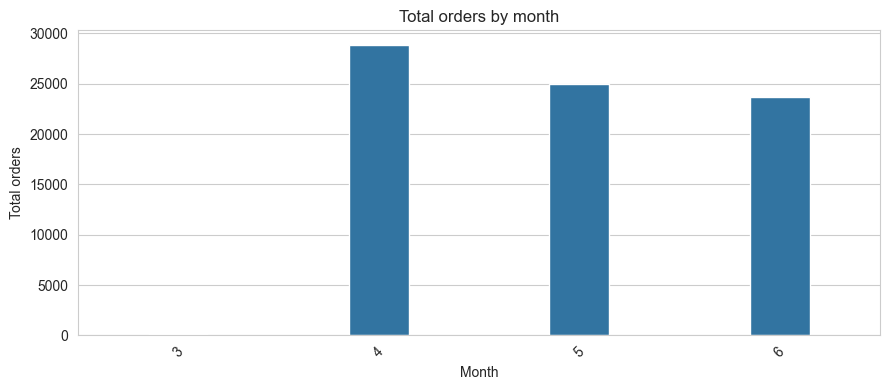

In [95]:
plt.figure(figsize=(9, 4))
sns.barplot(data=df_month, x="month", y="orders", width=0.3)

plt.title("Total orders by month")
plt.xlabel("Month")
plt.ylabel("Total orders")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()